# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/Users/guydavidson/anaconda/envs/fast-ai/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.363906
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** As the weights are random and uniform, we expect the class probabilities to be random and uniform as well. As we normalize, we expect each class probability to be about 1/k, for k classes. That includes the correct class probability (y_i), and hence the loss function for each example will be (on expectation) -log(1/k) = -log(0.1).


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.021097 analytic: -1.021097, relative error: 2.337798e-08
numerical: -0.198407 analytic: -0.198407, relative error: 6.628186e-08
numerical: 0.843434 analytic: 0.843434, relative error: 6.708236e-08
numerical: -2.463533 analytic: -2.463533, relative error: 4.442393e-08
numerical: 2.231680 analytic: 2.231679, relative error: 1.714866e-08
numerical: -0.715955 analytic: -0.715955, relative error: 1.054167e-07
numerical: -1.801875 analytic: -1.801875, relative error: 1.668338e-08
numerical: 0.135292 analytic: 0.135292, relative error: 1.839153e-07
numerical: -2.791508 analytic: -2.791508, relative error: 3.963117e-09
numerical: -2.655600 analytic: -2.655600, relative error: 1.131954e-08
numerical: -0.467616 analytic: -0.467616, relative error: 1.562108e-07
numerical: -0.338037 analytic: -0.338037, relative error: 6.387289e-08
numerical: 0.507842 analytic: 0.507842, relative error: 7.768526e-08
numerical: 0.345989 analytic: 0.345989, relative error: 1.995682e-08
numerical: -1.14

In [17]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.363906e+00 computed in 0.177444s
vectorized loss: 2.363906e+00 computed in 0.002689s
Loss difference: 0.000000
Gradient difference: 0.000000


In [25]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 1e-5]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
batch_sizes = (100, 200, 500, 1000, 1500)

LEARNING_RATES = 5
REG_STRENGTHS = 5
ITERATIONS = 1000

for learning_rate in np.linspace(*learning_rates, LEARNING_RATES):
    for reg in np.linspace(*regularization_strengths, REG_STRENGTHS):
        for batch_size in batch_sizes:
            softmax = Softmax()
            softmax.train(X_train, y_train, learning_rate, reg, ITERATIONS, batch_size, verbose=True)
            
            training_predictions = softmax.predict(X_train)
            training_accuracy = np.mean(y_train == training_predictions)
            
            validation_predictions = softmax.predict(X_val)
            validation_accuracy = np.mean(y_val == validation_predictions)
            print(learning_rate, reg, batch_size, training_accuracy, validation_accuracy)
            
            results[learning_rate, reg, batch_size] = training_accuracy, validation_accuracy
            if validation_accuracy > best_val:
                print('Found best validation accuracy so far', validation_accuracy)
                best_val = validation_accuracy
                best_softmax = softmax
                
                
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg, batch in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, batch)]
    print('lr %e reg %e batch %d train accuracy: %f val accuracy: %f' % (
                lr, reg, batch, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 774.688184
iteration 100 / 1000: loss 284.335092
iteration 200 / 1000: loss 105.261172
iteration 300 / 1000: loss 39.984193
iteration 400 / 1000: loss 15.963662
Stopping on iteration 435 since loss stagnates (loss = 11.853622, delta = 0.003766)
1e-07 25000.0 100 0.291142857143 0.311
Found best validation accuracy so far 0.311
iteration 0 / 1000: loss 767.866448
iteration 100 / 1000: loss 282.125719
iteration 200 / 1000: loss 104.502826
iteration 300 / 1000: loss 39.676073
iteration 400 / 1000: loss 15.802961
Stopping on iteration 486 since loss stagnates (loss = 7.896495, delta = 0.000742)
1e-07 25000.0 200 0.304734693878 0.308
iteration 0 / 1000: loss 782.463991
iteration 100 / 1000: loss 287.391487
iteration 200 / 1000: loss 106.482859
iteration 300 / 1000: loss 40.294545
iteration 400 / 1000: loss 16.092392
Stopping on iteration 451 since loss stagnates (loss = 10.492928, delta = 0.005493)
1e-07 25000.0 500 0.298775510204 0.327
Found best validation accuracy

iteration 0 / 1000: loss 978.725775
Stopping on iteration 28 since loss stagnates (loss = 2.195500, delta = 0.005518)
2.575e-06 31250.0 200 0.290204081633 0.29
iteration 0 / 1000: loss 960.461033
Stopping on iteration 29 since loss stagnates (loss = 2.197913, delta = 0.001466)
2.575e-06 31250.0 500 0.323653061224 0.327
iteration 0 / 1000: loss 969.335701
Stopping on iteration 28 since loss stagnates (loss = 2.164613, delta = 0.001873)
2.575e-06 31250.0 1000 0.312897959184 0.324
iteration 0 / 1000: loss 962.169479
Stopping on iteration 28 since loss stagnates (loss = 2.170879, delta = 0.009261)
2.575e-06 31250.0 1500 0.330408163265 0.34
iteration 0 / 1000: loss 1144.098037
Stopping on iteration 22 since loss stagnates (loss = 2.327050, delta = 0.002032)
2.575e-06 37500.0 100 0.261081632653 0.26
iteration 0 / 1000: loss 1143.454389
Stopping on iteration 28 since loss stagnates (loss = 2.151511, delta = 0.001201)
2.575e-06 37500.0 200 0.263836734694 0.275
iteration 0 / 1000: loss 1163.257

iteration 100 / 1000: loss 4.612678
Stopping on iteration 133 since loss stagnates (loss = 6.952146, delta = 0.006433)
7.525e-06 31250.0 100 0.144448979592 0.138
iteration 0 / 1000: loss 956.238298
Stopping on iteration 92 since loss stagnates (loss = 5.728586, delta = 0.004227)
7.525e-06 31250.0 200 0.165612244898 0.153
iteration 0 / 1000: loss 977.421790
iteration 100 / 1000: loss 3.898101
iteration 200 / 1000: loss 5.161252
iteration 300 / 1000: loss 5.859011
iteration 400 / 1000: loss 5.970360
iteration 500 / 1000: loss 4.988693
iteration 600 / 1000: loss 5.060298
iteration 700 / 1000: loss 5.125371
Stopping on iteration 778 since loss stagnates (loss = 5.357944, delta = 0.008426)
7.525e-06 31250.0 500 0.166367346939 0.159
iteration 0 / 1000: loss 977.716954
iteration 100 / 1000: loss 5.265188
iteration 200 / 1000: loss 4.750840
iteration 300 / 1000: loss 4.767595
iteration 400 / 1000: loss 5.144329
iteration 500 / 1000: loss 5.088867
iteration 600 / 1000: loss 4.217294
iteration 7

iteration 200 / 1000: loss 8.137384
iteration 300 / 1000: loss 7.848259
iteration 400 / 1000: loss 8.328656
iteration 500 / 1000: loss 8.345839
iteration 600 / 1000: loss 8.629742
iteration 700 / 1000: loss 7.778300
iteration 800 / 1000: loss 7.976142
iteration 900 / 1000: loss 8.522853
1e-05 31250.0 1500 0.0972653061224 0.072
iteration 0 / 1000: loss 1161.039763
iteration 100 / 1000: loss 8.852046
iteration 200 / 1000: loss 11.277033
iteration 300 / 1000: loss 9.000461
iteration 400 / 1000: loss 11.781984
iteration 500 / 1000: loss 10.616447
iteration 600 / 1000: loss 12.852773
iteration 700 / 1000: loss 11.641444
iteration 800 / 1000: loss 13.215834
iteration 900 / 1000: loss 13.140224
1e-05 37500.0 100 0.165387755102 0.162
iteration 0 / 1000: loss 1159.945939
iteration 100 / 1000: loss 11.271011
iteration 200 / 1000: loss 11.161952
iteration 300 / 1000: loss 10.167628
iteration 400 / 1000: loss 12.066852
iteration 500 / 1000: loss 9.019033
iteration 600 / 1000: loss 11.798041
Stoppi

In [26]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.327000


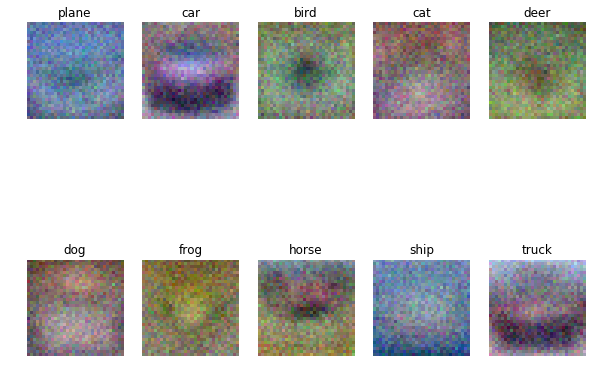

In [27]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [8]:
xw = np.matmul(X_dev, W)

In [9]:
maxes = xw[np.arange(500), np.argmax(xw, 1)]
maxes.shape = (500, 1)
fixed = xw - maxes
np.sum(fixed > 0)

0

In [10]:
np.sum(xw, 1).shape

(500,)

In [13]:
W.shape, xw.shape, X_dev.shape

((3073, 10), (500, 10), (500, 3073))